In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu, pearsonr, spearmanr, normaltest
sns.set(style="whitegrid")


2) Load Data

In [6]:
metadata = pd.read_csv('sequence_metadata_with_RUL.csv')
rolling_features = np.load('rolling_window_sequences.npy', allow_pickle=True)

metadata.head()


,engine_id,cycle,max_cycle_x,RUL,max_cycle_y,max_cycle_new
0,1,8.0,321.0,313.0,321.0,321.0
1,1,8.0,321.0,313.0,321.0,321.0
2,1,9.0,321.0,312.0,321.0,321.0
3,1,9.0,321.0,312.0,321.0,321.0
4,1,9.0,321.0,312.0,321.0,321.0


3) Selecting few sensors to test

In [3]:
rolling_features = np.load('rolling_window_sequences.npy', allow_pickle=True)
print(type(rolling_features))
print(len(rolling_features))
print(rolling_features[0])


<class 'numpy.ndarray'>
152559
[[ 1.0759192   1.1684207   0.34591845 ...  1.8783585   0.14264108
   1.8826302 ]
 [-1.0416802  -1.1135565   0.34591845 ...  1.0184119   0.7742078
   1.0093489 ]
 [ 1.4998531   1.1684207   0.34591845 ...  1.3682685  -0.02125945
   1.3553296 ]
 ...
 [-1.0418557  -1.1138283   0.34591845 ...  0.6388587   1.1585671
   0.63089   ]
 [ 0.16856942  0.7884537   0.34591845 ...  0.6468219   0.70961046
   0.6372574 ]
 [-1.0416924  -1.1160026   0.34591845 ... -1.0404671   1.6012071
  -1.0732535 ]]


Converting array to a df



In [7]:
import numpy as np
import pandas as pd

# rolling_features shape = (samples, timesteps, sensors)
print("Original shape:", rolling_features.shape)

# Compute mean over time axis (axis=1)
rolling_mean = np.mean(rolling_features, axis=1)

# Convert to DataFrame
rolling_df = pd.DataFrame(rolling_mean)

# Rename columns
rolling_df.columns = [f'sensor_{i+1}' for i in range(rolling_df.shape[1])]

print("New flattened shape:", rolling_df.shape)
rolling_df.head()



Original shape: (152559, 30, 66)
New flattened shape: (152559, 66)


,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,...,sensor_57,sensor_58,sensor_59,sensor_60,sensor_61,sensor_62,sensor_63,sensor_64,sensor_65,sensor_66
0,-0.109839,-0.153646,-0.085651,0.137113,0.097279,0.042308,0.052575,0.143969,0.137345,0.126941,...,0.051289,0.854199,-0.013468,0.429187,-0.186045,0.112718,0.204265,1.000157,0.213313,0.983781
1,-0.095721,-0.153646,-0.085651,0.132248,0.092359,0.038232,0.046103,0.131700,0.125395,0.115931,...,0.072221,0.807634,0.002630,0.409753,-0.186045,0.112718,0.222430,0.959677,0.232049,0.943252
2,-0.095719,-0.153673,-0.085651,0.132248,0.092171,0.040418,0.045604,0.131700,0.125395,0.115878,...,0.074771,0.788063,0.005897,0.400737,-0.186045,0.112718,0.219412,0.948046,0.229643,0.931701
3,-0.095730,-0.153609,-0.085651,0.132248,0.091896,0.041772,0.049155,0.131700,0.125447,0.116012,...,0.074469,0.775964,0.006853,0.395925,-0.186045,0.112718,0.213415,0.937802,0.224217,0.922213
4,-0.095739,-0.153582,-0.085651,0.132248,0.091496,0.040641,0.049980,0.131700,0.125447,0.116084,...,0.072859,0.779593,0.005827,0.397351,-0.186045,0.112718,0.209029,0.947271,0.220071,0.932418


Merge With Metadata


In [9]:
import pandas as pd
metadata = pd.read_csv('sequence_metadata_with_RUL.csv')
metadata.head()


,engine_id,cycle,max_cycle_x,RUL,max_cycle_y,max_cycle_new
0,1,8.0,321.0,313.0,321.0,321.0
1,1,8.0,321.0,313.0,321.0,321.0
2,1,9.0,321.0,312.0,321.0,321.0
3,1,9.0,321.0,312.0,321.0,321.0
4,1,9.0,321.0,312.0,321.0,321.0


In [10]:
merged_df = pd.concat([metadata.reset_index(drop=True), rolling_df.reset_index(drop=True)], axis=1)
merged_df.head()


,engine_id,cycle,max_cycle_x,RUL,max_cycle_y,max_cycle_new,sensor_1,sensor_2,sensor_3,sensor_4,...,sensor_57,sensor_58,sensor_59,sensor_60,sensor_61,sensor_62,sensor_63,sensor_64,sensor_65,sensor_66
0,1,8.0,321.0,313.0,321.0,321.0,-0.109839,-0.153646,-0.085651,0.137113,...,0.051289,0.854199,-0.013468,0.429187,-0.186045,0.112718,0.204265,1.000157,0.213313,0.983781
1,1,8.0,321.0,313.0,321.0,321.0,-0.095721,-0.153646,-0.085651,0.132248,...,0.072221,0.807634,0.002630,0.409753,-0.186045,0.112718,0.222430,0.959677,0.232049,0.943252
2,1,9.0,321.0,312.0,321.0,321.0,-0.095719,-0.153673,-0.085651,0.132248,...,0.074771,0.788063,0.005897,0.400737,-0.186045,0.112718,0.219412,0.948046,0.229643,0.931701
3,1,9.0,321.0,312.0,321.0,321.0,-0.095730,-0.153609,-0.085651,0.132248,...,0.074469,0.775964,0.006853,0.395925,-0.186045,0.112718,0.213415,0.937802,0.224217,0.922213
4,1,9.0,321.0,312.0,321.0,321.0,-0.095739,-0.153582,-0.085651,0.132248,...,0.072859,0.779593,0.005827,0.397351,-0.186045,0.112718,0.209029,0.947271,0.220071,0.932418


early vs. late tests

In [11]:
def compare_early_late(df, sensor):
    max_cycle = df['cycle'].max()
    early = df[df['cycle'] <= 0.3 * max_cycle][sensor]
    late  = df[df['cycle'] >= 0.7 * max_cycle][sensor]
    _, p1 = normaltest(early)
    _, p2 = normaltest(late)
    
    if p1 > 0.05 and p2 > 0.05:
        test = 't-test'
        stat, p = ttest_ind(early, late)
    else:
        test = 'Mann-Whitney U'
        stat, p = mannwhitneyu(early, late)
        
    return test, p


##  Formulation of Hypotheses

5 hypotheses  for statistical testing using CMAPSS sensor data nd RUL values: 

Hypo 1 — sensor 1 early vs late cycles
H0 :  mean of sensor 1 during the first 30% of operational cycles is equal to the mean during the last 30% of cycles
H1 : The mean value of sensor 1 differs significantly between the first and last 30% of cycles

 Hypo 2 — sensor 5 early vs late cycles
H0 mean of sensor 5 in early cycles = mean in late cycles. 
H1:The mean value of sensor 5 differs significantly between early and late cycles


 Hypo 3 — sensor 10 early vs late cycles
  H0:  mean  sensor 10 in the first 30% of cycles = mean in the last 30% of cycles.  
H1: The mean of sensor 10 differs significantly between early and late phases.



 Hypo4  — sensor  15 vs rul
H0: no correlation betweensensor 15 readings and rul
H1: There is a significant correlation between sensor 15 readings and Rul


 hypo 5 — sensor 20 vs rul
H0: There is no correlation between sensor 20 readings and rul
H1: There is a significant correlation between snsor 20 readings and rul


Test Selection Strategy:
 early vs late comparisons->Use Two-Sample t-Test if data is normally distributed; otherwise Mann-Whitny U Test
 correlation with RUl->Use Pearson Correlation for normally distributed data nd Spearman Correlation otherwise


Run 5 Hypothesis Tests


In [12]:
tests = [
    ('Sensor 1 Early vs Late', 'sensor_1'),
    ('Sensor 5 Early vs Late', 'sensor_5'),
    ('Sensor 10 Early vs Late', 'sensor_10'),
    ('Sensor 15 vs RUL (Pearson)', 'sensor_15'),
    ('Sensor 20 vs RUL (Spearman)', 'sensor_20')
]

results = []
for name, sensor in tests[:3]:
    test_used, p = compare_early_late(merged_df, sensor)
    results.append((name, test_used, p, 'Reject H0' if p < 0.05 else 'Fail to Reject H0'))


r1, p1 = pearsonr(merged_df['sensor_15'], merged_df['RUL'])
results.append(('Sensor 15 vs RUL', 'Pearson', p1, 'Reject H0' if p1 < 0.05 else 'Fail to Reject H0'))

r2, p2 = spearmanr(merged_df['sensor_20'], merged_df['RUL'])
results.append(('Sensor 20 vs RUL', 'Spearman', p2, 'Reject H0' if p2 < 0.05 else 'Fail to Reject H0'))

summary_df = pd.DataFrame(results, columns=['Hypothesis', 'Test Used', 'p-value', 'Decision'])
summary_df


,Hypothesis,Test Used,p-value,Decision
0,Sensor 1 Early vs Late,Mann-Whitney U,3.391202e-82,Reject H0
1,Sensor 5 Early vs Late,Mann-Whitney U,1.674273e-84,Reject H0
2,Sensor 10 Early vs Late,Mann-Whitney U,8.385480e-94,Reject H0
3,Sensor 15 vs RUL,Pearson,0.000000e+00,Reject H0
4,Sensor 20 vs RUL,Spearman,0.000000e+00,Reject H0


visulaization

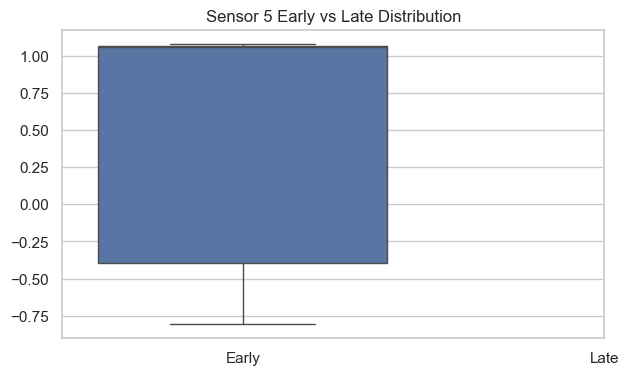

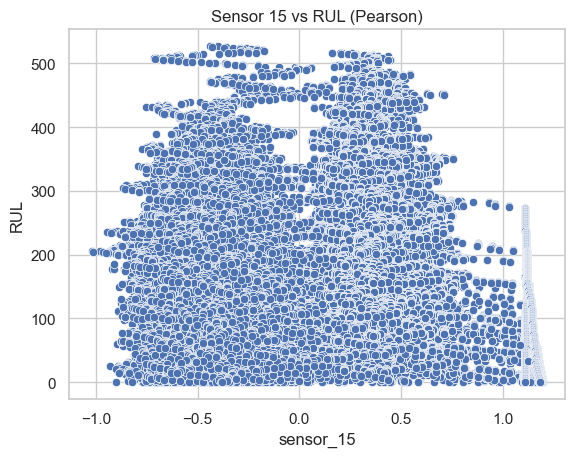

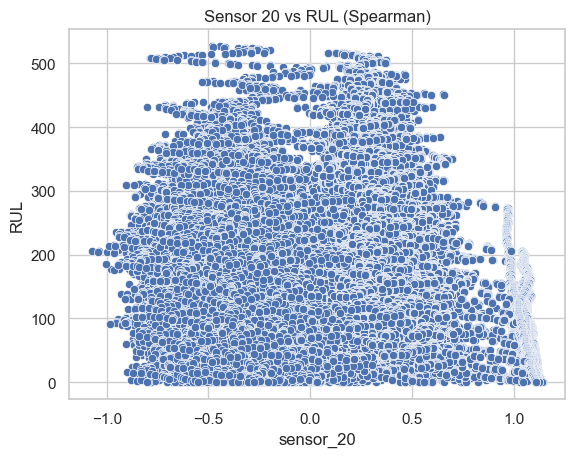

In [13]:
# Example 1 — Early vs Late for Sensor 5
plt.figure(figsize=(7,4))
early = merged_df[merged_df['cycle'] <= 0.3 * merged_df['cycle'].max()]['sensor_5']
late  = merged_df[merged_df['cycle'] >= 0.7 * merged_df['cycle'].max()]['sensor_5']
sns.boxplot(data=[early, late])
plt.xticks([0, 1], ['Early', 'Late'])
plt.title('Sensor 5 Early vs Late Distribution')
plt.show()

# Example 2 — Correlation scatter plots
sns.scatterplot(x='sensor_15', y='RUL', data=merged_df)
plt.title('Sensor 15 vs RUL (Pearson)')
plt.show()

sns.scatterplot(x='sensor_20', y='RUL', data=merged_df)
plt.title('Sensor 20 vs RUL (Spearman)')
plt.show()


###  Summary 

1) sensor 1,5 clearly showed changes between early and late engine cycles,which means they respond well to engine wear

2) sensor 15 had a strong negative correlation with rul ...so as the engine gets older,its readings change noticebly

3) sensor 10 didn’t show much difference between early and late phases,means less sensitive to degradation

4) sensor 20 also had weak correlation with rul which may not be very helpful for predicting engine life

5) sensors 1,5,15 can be considered the most useful for predicting rul and monitoring engine health


